In [2]:
import dill
import re
from ediblepickle import checkpoint
import pandas as pd
from glob import glob
import altair as alt
import json
import geopandas as gpd

# Building info from Street Easy
https://streeteasy.com/buildings/manhattan

Previous Thoughts: I had streeteasy return all rental listings from 5 boroughs on Monday April 13, 2021.
https://streeteasy.com/for-rent/nyc/area:100,300,400,200,500


However StreetEasy has a bot blocker. Instead I tried using an open source web scraper to get data. But his is slow, and I would need 6 days to extract data from all boroughs. Instead, I am doing it for manhattan only.
One other option would be to use zillow's api.https://www.zillowgroup.com/developers/public-data/. This returns address and maybe Zestimate.
Streeteasy tends to more often have details about the building and price history, which may be more predictive of complaints. Step 1: Using Web Scraper, scrape 2667 pages of manhattan buildings data. Process started on April 13th at 9:15pm.
Only 1000 pages at a time are allowed on Web Scraper. Min 4000 ms request rate, 1000 pg load delay.

In [50]:
files =  []
for item in glob("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/m*.csv"):
    files.append(item)
print(files)

['/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0200-0300.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0901-1000.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_1120-1200.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0500-0600.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0001-0099.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_1001-1100.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0600-0700.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0100-0200.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0701-0800.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0801-0900.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_1226-1300.csv', '/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/mahnattan_bl_0300-0400.csv']


## BUILDING DATA CONCAT AND CLEAN

In [51]:
frames = []
for file in files:
    x = pd.read_csv(file, dtype = {'address': str}, low_memory = False)
    frames.append(x)
    
df = pd.concat(frames)

In [52]:
df.head()

,web-scraper-order,web-scraper-start-url,building_names,building_names-href,address,units,stories,built,unit_type,neighborhood,...,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61
0,1618450083-4185,https://streeteasy.com/buildings/manhattan?pag...,235 West 63rd Street,https://streeteasy.com/building/235-west-63-st...,"235 West 63rd Street, New York, NY, 10023",41 units,8 stories,Built in 1907,Rental Building,Lincoln Square,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1618449871-4137,https://streeteasy.com/buildings/manhattan?pag...,1774 Amsterdam Avenue,https://streeteasy.com/building/1774-amsterdam...,"1774 Amsterdam Avenue, New York, NY, 10031",28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1618450019-4171,https://streeteasy.com/buildings/manhattan?pag...,215 East 88th Street,https://streeteasy.com/building/215-east-88-st...,"215 East 88th Street, New York, NY, 10128",20 units,5 stories,Built in 1920,Co-op,Yorkville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1618446088-3291,https://streeteasy.com/buildings/manhattan?pag...,Hanley New York,https://streeteasy.com/building/hanley-new-york,"165 East 66th Street, New York, NY, 10065",150 units,21 stories,Built in 1957,NaN,Lenox Hill,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1618449796-4120,https://streeteasy.com/buildings/manhattan?pag...,545 West 158th Street,https://streeteasy.com/building/545-west-158-s...,"545 West 158th Street, New York, NY, 10032",36 units,6 stories,Built in 1911,Rental Building,Washington Heights,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
boolean = df["address"].duplicated().any()

In [54]:
boolean #### MINE MORE DATA FROM HERE- MALFORMED DATA THROWN OUT

True

In [55]:
df_dedupe = df.drop_duplicates(subset =["address"], keep = "first")

In [56]:
boolean = df_dedupe["address"].duplicated().any()

In [57]:
boolean

False

In [58]:
len(df_dedupe)

10081

In [59]:
cols = ['address', 'units', 'stories', 'built', 
        'unit_type', 'neighborhood', 'popularity', 'location']
building_df = df_dedupe[cols]
building_df.shape

(10081, 8)

### split street address

In [60]:
building_df[["st_address", "city","st","zipcode"]] = building_df.address.str.split(",", expand = True)

/Users/bs/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [61]:
building_df.head()

,address,units,stories,built,unit_type,neighborhood,popularity,location,st_address,city,st,zipcode
0,"235 West 63rd Street, New York, NY, 10023",41 units,8 stories,Built in 1907,Rental Building,Lincoln Square,This building has been saved by 134 users.,NaN,235 West 63rd Street,New York,NY,10023
1,"1774 Amsterdam Avenue, New York, NY, 10031",28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,NaN,1774 Amsterdam Avenue,New York,NY,10031
2,"215 East 88th Street, New York, NY, 10128",20 units,5 stories,Built in 1920,Co-op,Yorkville,This building has been saved by 110 users.,NaN,215 East 88th Street,New York,NY,10128
3,"165 East 66th Street, New York, NY, 10065",150 units,21 stories,Built in 1957,NaN,Lenox Hill,This building has been saved by 890 users.,NaN,165 East 66th Street,New York,NY,10065
4,"545 West 158th Street, New York, NY, 10032",36 units,6 stories,Built in 1911,Rental Building,Washington Heights,This building has been saved by 3 users.,NaN,545 West 158th Street,New York,NY,10032


In [62]:
building_df["st_address_lower"] = building_df["st_address"].str.lower()

<ipython-input-62-59d1fcfd1b37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_df["st_address_lower"] = building_df["st_address"].str.lower()


In [63]:
df_nona = building_df.dropna(subset = ['zipcode',"st_address"]) #remove nas

In [64]:
df_nona["zipcode"] = df_nona["zipcode"].apply(int)

<ipython-input-64-3fdb4f81767f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nona["zipcode"] = df_nona["zipcode"].apply(int)


In [65]:
df_nona.head()

,address,units,stories,built,unit_type,neighborhood,popularity,location,st_address,city,st,zipcode,st_address_lower
0,"235 West 63rd Street, New York, NY, 10023",41 units,8 stories,Built in 1907,Rental Building,Lincoln Square,This building has been saved by 134 users.,NaN,235 West 63rd Street,New York,NY,10023,235 west 63rd street
1,"1774 Amsterdam Avenue, New York, NY, 10031",28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,NaN,1774 Amsterdam Avenue,New York,NY,10031,1774 amsterdam avenue
2,"215 East 88th Street, New York, NY, 10128",20 units,5 stories,Built in 1920,Co-op,Yorkville,This building has been saved by 110 users.,NaN,215 East 88th Street,New York,NY,10128,215 east 88th street
3,"165 East 66th Street, New York, NY, 10065",150 units,21 stories,Built in 1957,NaN,Lenox Hill,This building has been saved by 890 users.,NaN,165 East 66th Street,New York,NY,10065,165 east 66th street
4,"545 West 158th Street, New York, NY, 10032",36 units,6 stories,Built in 1911,Rental Building,Washington Heights,This building has been saved by 3 users.,NaN,545 West 158th Street,New York,NY,10032,545 west 158th street


In [66]:
len(df_nona)

10001

# 311 data

In [10]:
data311 = pd.read_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/311_Service_Requests_from_2010_to_Present.csv")

/Users/bs/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,17,18,20,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
data311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [12]:
cols_to_keep =['Unique Key','Complaint Type','Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2','Borough',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type','X Coordinate (State Plane)',
       'Y Coordinate (State Plane)','Latitude', 'Longitude']
data_311 = data311[cols_to_keep]

In [13]:
data_311["Borough"].unique

<bound method Series.unique of 0           BROOKLYN
1           BROOKLYN
2             QUEENS
3             QUEENS
4             QUEENS
             ...    
5458005       QUEENS
5458006    MANHATTAN
5458007    MANHATTAN
5458008       QUEENS
5458009        BRONX
Name: Borough, Length: 5458010, dtype: object>

In [14]:
data_311_man = data_311[data_311["Borough"] == "MANHATTAN"]

In [15]:
len(data_311_man)

1086125

### Clean up the 311 data - remove nas, format zipcode

In [16]:
data_311_man_zips = data_311_man.dropna(subset = ['Incident Zip',"Complaint Type"]) #remove nas

In [17]:
data_311_man_zips

,Unique Key,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Borough,Intersection Street 1,Intersection Street 2,Address Type,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude
6,41327465,Street Condition,Pothole,NaN,10031.0,WEST 139 STREET,WEST 139 STREET,AMSTERDAM AVENUE,HAMILTON PLACE,MANHATTAN,NaN,NaN,BLOCKFACE,997745.0,238688.0,40.821809,-73.951242
7,41307350,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10003.0,106 3 AVENUE,3 AVENUE,EAST 13 STREET,EAST 14 STREET,MANHATTAN,NaN,NaN,ADDRESS,987682.0,206223.0,40.732710,-73.987617
9,41320918,Street Condition,Pothole,NaN,10027.0,BROADWAY,BROADWAY,WEST 131 STREET,WEST 132 STREET,MANHATTAN,NaN,NaN,BLOCKFACE,996232.0,237249.0,40.817861,-73.956711
37,41312522,Noise - Residential,Loud Music/Party,Residential Building/House,10029.0,171 EAST 115 STREET,EAST 115 STREET,LEXINGTON AVENUE,3 AVENUE,MANHATTAN,NaN,NaN,ADDRESS,1000493.0,229876.0,40.797618,-73.941334
39,41309288,Noise - Residential,Loud Music/Party,Residential Building/House,10014.0,95 HORATIO STREET,HORATIO STREET,WASHINGTON STREET,JOE DIMAGGIO HIGHWAY,MANHATTAN,NaN,NaN,ADDRESS,981897.0,208427.0,40.738760,-74.008491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457997,50130883,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10025.0,WEST 93 STREET,WEST 93 STREET,WEST 93 STREET,WEST END AVENUE,MANHATTAN,WEST 93 STREET,WEST END AVENUE,NaN,991279.0,228308.0,40.793326,-73.974615
5457999,50127182,Noise - Residential,Loud Music/Party,Residential Building/House,10014.0,200 WAVERLY PLACE,WAVERLY PLACE,WEST 10 STREET,CHARLES STREET,MANHATTAN,WEST 10 STREET,CHARLES STREET,NaN,983838.0,206980.0,40.734789,-74.001487
5458004,50123291,Traffic,Drag Racing,Street/Sidewalk,10040.0,131 FT GEORGE AVENUE,FT GEORGE AVENUE,BEND,TED BUCZEK WAY,MANHATTAN,BEND,TED BUCZEK WAY,NaN,1003975.0,251225.0,40.856207,-73.928696
5458006,50127582,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10040.0,BROADWAY,BROADWAY,BROADWAY,DONGAN PLACE,MANHATTAN,BROADWAY,DONGAN PLACE,NaN,1003605.0,253854.0,40.863424,-73.930026


Fix Column formats

In [18]:
data_311_man_zips['zipcode'] = data_311_man_zips['Incident Zip'].apply(int)

<ipython-input-18-5122c55c6f69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_311_man_zips['zipcode'] = data_311_man_zips['Incident Zip'].apply(int)


In [19]:
data_311_man_zips["Incident_Address_lower"] = data_311_man_zips["Incident Address"].str.lower()

<ipython-input-19-6eccbe1c2f01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_311_man_zips["Incident_Address_lower"] = data_311_man_zips["Incident Address"].str.lower()


In [21]:
data_311_man_zips.head()
data_311_man_zips.to_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/data_311_man_zips.csv")

# THE JOIN

In [67]:
df_nona.shape

(10001, 13)

In [49]:
data_311_man_zips = pd.read_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/data_311_man_zips.csv")

In [68]:
merged_df = df_nona.merge(data_311_man_zips, left_on = ["zipcode","st_address_lower"], right_on = ["zipcode", "Incident_Address_lower"])

In [69]:
merged_df.shape

(62350, 32)

In [70]:
merged_df.columns

Index(['address', 'units', 'stories', 'built', 'unit_type', 'neighborhood',
       'popularity', 'location', 'st_address', 'city', 'st', 'zipcode',
       'st_address_lower', 'Unnamed: 0', 'Unique Key', 'Complaint Type',
       'Descriptor', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'Cross Street 1', 'Cross Street 2', 'Borough',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude',
       'Longitude', 'Incident_Address_lower'],
      dtype='object')

In [119]:
merged_df.to_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/first_merge.csv")

### cleaning up merged df for ML pipeline

In [88]:
merged_df = pd.read_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/first_merge.csv")

In [89]:
cols_to_keep = ['st_address_lower','Complaint Type','zipcode',"units","stories","built","unit_type","neighborhood","popularity"]

merged_df_1 = merged_df[cols_to_keep]

In [90]:
merged_df_1.head()

,st_address_lower,Complaint Type,zipcode,units,stories,built,unit_type,neighborhood,popularity
0,1774 amsterdam avenue,Damaged Tree,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.
1,1774 amsterdam avenue,Non-Emergency Police Matter,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.
2,1774 amsterdam avenue,Consumer Complaint,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.
3,1774 amsterdam avenue,Noise - Street/Sidewalk,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.
4,68 bayard street,Drinking Water,10013,16 units,6 stories,Built in 1915,Rental Building,Chinatown,This building has been saved by 6 users.


In [91]:
merged_df_1[["Units","text"]] = merged_df_1.units.str.split(" ", expand = True)

/Users/bs/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [92]:
merged_df_1[["Stories","text2","text3"]] = merged_df_1.stories.str.split(" ", expand = True)

In [93]:
merged_df_1[["text4","text5","Built","text6"]] = merged_df_1.built.str.split(" ", expand = True)

In [94]:
merged_df_1[["text7","text8","text9","text10","text11","text12","Popularity","users"]] = merged_df_1.popularity.str.split(" ", expand = True)

In [95]:
merged_df_1.head()

,st_address_lower,Complaint Type,zipcode,units,stories,built,unit_type,neighborhood,popularity,Units,...,Built,text6,text7,text8,text9,text10,text11,text12,Popularity,users
0,1774 amsterdam avenue,Damaged Tree,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,28,...,1930,None,This,building,has,been,saved,by,23,users.
1,1774 amsterdam avenue,Non-Emergency Police Matter,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,28,...,1930,None,This,building,has,been,saved,by,23,users.
2,1774 amsterdam avenue,Consumer Complaint,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,28,...,1930,None,This,building,has,been,saved,by,23,users.
3,1774 amsterdam avenue,Noise - Street/Sidewalk,10031,28 units,5 stories,Built in 1930,Rental Building,Hamilton Heights,This building has been saved by 23 users.,28,...,1930,None,This,building,has,been,saved,by,23,users.
4,68 bayard street,Drinking Water,10013,16 units,6 stories,Built in 1915,Rental Building,Chinatown,This building has been saved by 6 users.,16,...,1915,None,This,building,has,been,saved,by,6,users.


In [96]:
cols_to_keep = ["st_address_lower",'Complaint Type','zipcode',"Units","Stories","Built","unit_type","neighborhood","Popularity"]

merged_df_2 = merged_df_1[cols_to_keep]

In [97]:
merged_df_2.head()

,st_address_lower,Complaint Type,zipcode,Units,Stories,Built,unit_type,neighborhood,Popularity
0,1774 amsterdam avenue,Damaged Tree,10031,28,5,1930,Rental Building,Hamilton Heights,23
1,1774 amsterdam avenue,Non-Emergency Police Matter,10031,28,5,1930,Rental Building,Hamilton Heights,23
2,1774 amsterdam avenue,Consumer Complaint,10031,28,5,1930,Rental Building,Hamilton Heights,23
3,1774 amsterdam avenue,Noise - Street/Sidewalk,10031,28,5,1930,Rental Building,Hamilton Heights,23
4,68 bayard street,Drinking Water,10013,16,6,1915,Rental Building,Chinatown,6


<AxesSubplot:>

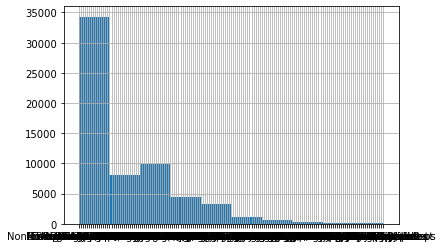

In [84]:
merged_df_2["Complaint Type"].hist()

In [85]:
complaints = merged_df_2.groupby(by = "Complaint Type", axis = 0)

In [171]:
complaint_counts = complaints.count()

In [172]:
complaint_counts = complaint_counts["zipcode"]

In [187]:
complaint_counts.sort_values().head(151)

Complaint Type
X-Ray Machine/Equipment       1
Vacant Lot                    1
Foam Ban Enforcement          1
Green Taxi Complaint          1
Green Taxi Report             1
                           ... 
Noise                      3119
Illegal Parking            3230
Noise - Street/Sidewalk    5235
Noise - Residential        7724
HEAT/HOT WATER             8989
Name: zipcode, Length: 151, dtype: int64

<AxesSubplot:>

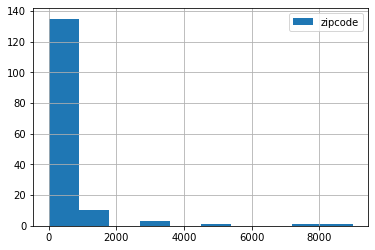

In [176]:
complaint_counts.hist(legend = True)

In [98]:
clean_merged_df = merged_df_2

In [99]:
clean_merged_df.to_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/clean_merge.csv")

# 311 data  Analysis

In [100]:
data_311_man_zips = pd.read_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/data_311_man_zips.csv")

In [108]:
data_311_man_zips["Incident Zip"].dtype

dtype('float64')

In [103]:
data = data_311_man_zips

In [104]:
out_noise = ["Noise - Street/Sidewalk", "Noise - Commercial", "Noise", "Noise - Vehicle", "Noise - Helicopter" ]
apt = ["PAINT/PLASTER","DOOR/WINDOW", "General Construction/Plumbing", "APPLIANCE"]
water =["PLUMBING", "Water System", "WATER LEAK", "Water Quality","Sewer", "Plumbing"]
bldg = ["FLOORING/STAIRS","Elevator","Building/Use","Maintenance or Facility"]
heat = ["HEAT/HOT WATER", "ELECTRIC"]
noise = ["Noise - Residential"]
parking = ["Illegal Parking","Street Condition", "Blocked Driveway","Graffiti","Sidewalk Condition","Street Light Condition","Dead/Dying Tree"]
health = ["Unsanitary Condition", "Lead", "Dirty Conditions", "Air Quality", "Indoor Air Quality","SAFETY","Sanitation Condition"]

In [105]:
data = data.replace(to_replace = out_noise, value = "Noise - Outside")
data = data.replace(to_replace = apt, value = "Apartment Construction/Maintenance")
data = data.replace(to_replace = water, value = "Water Leaks and Plumbing")
data = data.replace(to_replace = bldg, value = "Building Maintenance")
data = data.replace(to_replace = heat, value = "Heat/Hot Water/Electricity")
data = data.replace(to_replace = noise, value = "Noise - Residential")
data = data.replace(to_replace = parking, value = "Parking/Street Conditions")
data = data.replace(to_replace = health, value = "Unhealthy Conditions")

In [109]:
complaints_to_keep = ["st_address_lower","Rodent","Unhealthy Conditions","Parking/Street Conditions","Noise - Residential","Heat/Hot Water/Electricity","Building Maintenance","Water Leaks and Plumbing","Apartment Construction/Maintenance","Noise - Outside"]
filtered_data = data[data["Complaint Type"].isin(complaints_to_keep)]
filtered_data["Incident Zip"] = filtered_data["Incident Zip"].apply(str)

<ipython-input-109-19227807526b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Incident Zip"] = filtered_data["Incident Zip"].apply(str)


In [111]:
cols_to_keep = ["Complaint Type", "Incident Zip"]
final_data = filtered_data[cols_to_keep]

In [122]:
final_data.to_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/data_311_man_zips_final_complaints.csv")

In [112]:
y = final_data["Complaint Type"]
X = final_data.drop(labels = "Complaint Type", axis = 1)

In [116]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

transformer_name = 'ohe_on_all_categorical_features'
transformer = OneHotEncoder(sparse=False)
columns_to_encode = ['Incident Zip']

ohe_final = ColumnTransformer([
    (transformer_name, transformer, columns_to_encode)], 
    remainder='passthrough')

imputer = SimpleImputer(strategy = 'median', fill_value = 0)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of the complete data set:", X.shape)
print("Shape of the train data set:", X_train.shape)
print("Shape of the test data set:", X_test.shape)

Shape of the complete data set: (770692, 1)
Shape of the train data set: (616553, 1)
Shape of the test data set: (154139, 1)


In [118]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(LogisticRegression(max_iter = 1000), cv = 5, param_grid = {'C':[1,2]})
lr_pipe = Pipeline([('ohe', ohe_final),
                    ('imputer', imputer),
                    ('scaler', StandardScaler()),
                    ('gs', grid_search)])
                           
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_on_all_categorical_features',
                                                  OneHotEncoder(sparse=False),
                                                  ['Incident Zip'])])),
                ('imputer', SimpleImputer(fill_value=0, strategy='median')),
                ('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
                              param_grid={'C': [1, 2]}))])

In [120]:
from sklearn import metrics

def model_evaluation(model, X, y_true):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred, average='weighted'), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred, average='weighted'), 4)
    probs = model.predict_proba(X).T[1]
    #scores['log_loss'] = round(metrics.log_loss(y_true,probs),4)
    return scores

def print_model_evaluation(model_name, scores):
    print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))

In [121]:
lr_pipe_score = model_evaluation(lr_pipe, X_test, y_test)
print_model_evaluation('Logistic regression', lr_pipe_score)

/Users/bs/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic regression evaluation 

Test accuracy: 0.3179
Test precision: 0.2694
Test recall: 0.3179


In [119]:
import dill

with open('pipe_of_logreg_ZIP.dill', 'wb') as f:
    dill.dump(lr_pipe, f)

### Logistic Regression Performance for zipcode only model
Logistic regression evaluation 

Test accuracy: 0.3179
Test precision: 0.2694
Test recall: 0.3179

## HERE ON IS VISUALZAION~

In [188]:
data_311_man_zips = pd.read_csv("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/data_311_man_zips_final_complaints.csv")
data_311_man_zip_counts = data_311_man_zips.groupby(["Incident Zip","Complaint Type"]).agg(count_col= pd.NamedAgg(column="Complaint Type", aggfunc="count")).reset_index()

In [218]:
data_311_man_zip_counts["count_col_yr"]= data_311_man_zip_counts["count_col"]/5

In [219]:
data_311_man_zip_counts.head()

,Incident Zip,Complaint Type,count_col,count_col_yr
0,83.0,Noise - Outside,3,0.75
1,83.0,Parking/Street Conditions,4,1.00
2,10000.0,Apartment Construction/Maintenance,1,0.25
3,10000.0,Building Maintenance,20,5.00
4,10000.0,Noise - Outside,121,30.25


logistic regression scikit learn had a way to balance the classes. a

also has the c which is a regularization pareameter. Definitely read the whole logistic reression scikitlean page

In [220]:
len(pd.unique(data_311_man_zip_counts["Complaint Type"]))

9

VISUALIZING WITH ALTAIR

In [221]:
nycmap = json.load(open("/Users/bs/Projects/R_F_GitHub/nyc-complaints/data/zip_geojson.json"))


In [222]:
gdf = gpd.GeoDataFrame.from_features((nycmap))

In [223]:
gdf.head() # this contains more data than we need

,geometry,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude
0,"POLYGON ((-73.86942 40.74916, -73.89143 40.746...",1,11372,Jackson Heights,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.883573,40.751662
1,"POLYGON ((-73.71133 40.74947, -73.71068 40.750...",2,11004,Glen Oaks,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.711608,40.745366
2,"POLYGON ((-73.70098 40.73890, -73.70309 40.744...",3,11040,New Hyde Park,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.703443,40.748714
3,"POLYGON ((-73.72270 40.75373, -73.72251 40.753...",4,11426,Bellerose,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.724004,40.736534
4,"POLYGON ((-73.81089 40.72717, -73.81116 40.728...",5,11365,Fresh Meadows,NY,Queens,36,081,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.794626,40.739903


In [224]:
gdf['zipcode'] = gdf['postalCode'].apply(int)

In [225]:
len(pd.unique(gdf['zipcode']))

247

In [226]:
len(gdf)

262

In [227]:
len(data_311_man_zip_counts)

619

In [228]:
gdf_merged = gdf.merge(data_311_man_zip_counts, left_on ='zipcode', right_on = 'Incident Zip', how = 'inner')

In [229]:
gdf_merged.columns

Index(['geometry', 'OBJECTID', 'postalCode', 'PO_NAME', 'STATE', 'borough',
       'ST_FIPS', 'CTY_FIPS', 'BLDGpostal', '@id', 'longitude', 'latitude',
       'zipcode', 'Incident Zip', 'Complaint Type', 'count_col',
       'count_col_yr'],
      dtype='object')

In [230]:
pd.unique(gdf_merged["Complaint Type"])

array(['Apartment Construction/Maintenance', 'Building Maintenance',
       'Heat/Hot Water/Electricity', 'Noise - Outside',
       'Noise - Residential', 'Parking/Street Conditions', 'Rodent',
       'Unhealthy Conditions', 'Water Leaks and Plumbing'], dtype=object)

In [231]:
len(gdf_merged)

645

311 data has been merged with polygons

### Noise only

In [232]:
gdf_merged_noise = gdf_merged[gdf_merged["Complaint Type"] == 'Noise - Residential']

In [233]:
len(gdf_merged_noise)

63

In [234]:
choro_json = json.loads(gdf_merged_noise.to_json())
choro_data = alt.Data(values=choro_json['features'])

In [235]:
choro_json

{'type': 'FeatureCollection',
 'features': [{'id': '4',
   'type': 'Feature',
   'properties': {'@id': 'http://nyc.pediacities.com/Resource/PostalCode/10463',
    'BLDGpostal': 0,
    'CTY_FIPS': '005',
    'Complaint Type': 'Noise - Residential',
    'Incident Zip': 10463.0,
    'OBJECTID': 43,
    'PO_NAME': 'Bronx',
    'STATE': 'NY',
    'ST_FIPS': '36',
    'borough': 'Bronx',
    'count_col': 319,
    'count_col_yr': 79.75,
    'latitude': 40.881845296,
    'longitude': -73.907704482,
    'postalCode': '10463',
    'zipcode': 10463},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.92064636455858, 40.88723759323029],
      [-73.92037598363439, 40.88714599598992],
      [-73.91821298861579, 40.892780986737506],
      [-73.91648720470647, 40.89316183592988],
      [-73.91697388338743, 40.891962556151775],
      [-73.91795299427515, 40.89032043768567],
      [-73.9186549119368, 40.88838640755155],
      [-73.91863117303215, 40.88606109361414],
      [-73.9187615073836, 4

In [280]:
def gen_map(geodata, color_column, title, tooltip, color_scheme):
    '''
    Generates NYC ZIPCODES map with complaint type count choropleth
    '''
    selection = alt.selection_multi(fields=[color_column])
    color = alt.condition(selection,
              alt.Color(color_column, type='quantitative',
              scale=alt.Scale(scheme=color_scheme)),
              alt.value('blue'))
    
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=500,
        height=500
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  title = "Noise counts per year"),
         tooltip=tooltip
    )
   
    return base + choro

In [282]:
nyc_map = gen_map(geodata=choro_data, color_column='properties.count_col_yr', title='Residential Noise complaints by zipcode', tooltip=['properties.zipcode:O','properties.count_col_yr:Q'],color_scheme = "redblue")
nyc_map.save('nyc_noise.json')
nyc_map

alt.LayerChart(...)

In [264]:
choro_json = json.loads(gdf_merged.to_json())
choro_data = alt.Data(values=choro_json['features'])

In [154]:
def gen_map(geodata, color_column, title, tooltip, color_scheme='bluegreen'):
    '''
    Generates NYC ZIPCODES map with complaint type count choropleth
    '''
    selection = alt.selection_multi(fields=[color_column])
    color = alt.condition(selection,
              alt.Color(color_column, type='nominal',
              scale=alt.Scale(scheme=color_scheme)),
              alt.value('lightgray'))
    # Add Base Layer
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=500,
        height=500
    )
    # Add Choropleth Layer
    choro = alt.Chart(geodata).mark_geoshape(
        stroke='black'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme = color_scheme),
                  title = "Complaint Type"),
         tooltip=tooltip
    ).add_selection(
        selection
    )
    return base + choro

SyntaxError: invalid syntax (<ipython-input-154-980df0bcbe1e>, line 19)

In [155]:
nyc_map = gen_map(geodata=choro_data, color_column='properties.Complaint Type', title='Noise complaints by zipcode', tooltip=['properties.zipcode:O','properties.Unique Key:Q'], color_scheme='bluegreen')
nyc_map

alt.LayerChart(...)